# Emotion detection in texts


source: https://github.com/elyesaseidel/TweetsSentimentAnalysis/blob/main/TweetsSentimentPredictions.ipynb 

In [5]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Path to the folder "motion_to_emotion"
%cd drive/MyDrive/motion_to_emotion/

/content/drive/MyDrive/motion_to_emotion


# Imports

In [7]:
import re
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim
from sklearn.model_selection import train_test_split
import spacy
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
print('Done')

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Done


# Data importing

In [8]:
train = pd.read_csv("7_emotion.csv")

# Data exploration

In [9]:
train.head(15)

,Emotion,Text
0,neutral,Why ?
1,joy,Sage Act upgrade on my to do list for tommorow.
2,sadness,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...
3,joy,Such an eye ! The true hazel eye-and so brill...
4,joy,@Iluvmiasantos ugh babe.. hugggzzz for u .! b...
5,fear,I'm expecting an extremely important phonecall...
6,sadness,.Couldnt wait to see them live. If missing th...
7,surprise,maken Tip 2: Stop op een moment dat je het hel...
8,surprise,En dan krijg je ff een cadeautje van een tweep...
9,surprise,@1116am Drummer Boy bij op verzoek van @BiemO...


In [10]:
# Dataset lenght
len(train)

34792

In [11]:
# Is there any other different value than neutral, negative and positive?
train['Emotion'].unique()

array(['neutral', 'joy', 'sadness', 'fear', 'surprise', 'anger', 'shame',
       'disgust'], dtype=object)

In [12]:
# Drop 'shame'
train.drop(train[train.Emotion == 'shame'].index, inplace=True)

In [13]:
# Distribution of the data 
train.groupby('Emotion').nunique()

,Text
Emotion,
anger,3777
disgust,855
fear,4266
joy,10464
neutral,1466
sadness,6175
surprise,4015


# Data cleaning

In [14]:
#Let's keep only the columns that we're going to use
train = train[['Emotion','Text']]
train.head()

,Emotion,Text
0,neutral,Why ?
1,joy,Sage Act upgrade on my to do list for tommorow.
2,sadness,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...
3,joy,Such an eye ! The true hazel eye-and so brill...
4,joy,@Iluvmiasantos ugh babe.. hugggzzz for u .! b...


In [15]:
#Is there any null value?
train["Text"].isnull().sum()

0

### The next steps about data cleaning will be:

* Remove URLs from the tweets
* Tokenize text
* Remove emails
* Remove new lines characters
* Remove distracting single quotes
* Remove all punctuation signs
* Lowercase all text
* Detokenize text
* Convert list of texts to Numpy array

In [16]:
def depure_data(data):
    
    # Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

In [17]:
temp = []
# Splitting pd.Series to list
data_to_list = train['Text'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:5])

[' Why ? ',
 'Sage Act upgrade on my to do list for tommorow.',
 'ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN I HATE FUNERALS THIS REALLY SHOWS ME HOW BLESSED I AM ',
 ' Such an eye ! The true hazel eye-and so brilliant ! Regular features , open countenance , with a complexion , Oh ! What a bloom of full health , and such a pretty height and size ; such a firm and upright figure ! There is health , not merely in her bloom , but in her air , her head , her glance . One hears sometimes of a child being  the picture of health  ; now , she always gives me the idea of being the complete picture of grown-up health . She is loveliness itself . ',
 'ugh babe.. hugggzzz for u .! babe naamazed nga ako e babe e, despite negas mas pinaramdam at fil ko ang ']

In [18]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

data_words = list(sent_to_words(temp))

print(data_words[:10])

[['why'], ['sage', 'act', 'upgrade', 'on', 'my', 'to', 'do', 'list', 'for', 'tommorow'], ['on', 'the', 'way', 'to', 'my', 'homegirl', 'baby', 'funeral', 'man', 'hate', 'funerals', 'this', 'really', 'shows', 'me', 'how', 'blessed', 'am'], ['such', 'an', 'eye', 'the', 'true', 'hazel', 'eye', 'and', 'so', 'brilliant', 'regular', 'features', 'open', 'countenance', 'with', 'complexion', 'oh', 'what', 'bloom', 'of', 'full', 'health', 'and', 'such', 'pretty', 'height', 'and', 'size', 'such', 'firm', 'and', 'upright', 'figure', 'there', 'is', 'health', 'not', 'merely', 'in', 'her', 'bloom', 'but', 'in', 'her', 'air', 'her', 'head', 'her', 'glance', 'one', 'hears', 'sometimes', 'of', 'child', 'being', 'the', 'picture', 'of', 'health', 'now', 'she', 'always', 'gives', 'me', 'the', 'idea', 'of', 'being', 'the', 'complete', 'picture', 'of', 'grown', 'up', 'health', 'she', 'is', 'loveliness', 'itself'], ['ugh', 'babe', 'hugggzzz', 'for', 'babe', 'naamazed', 'nga', 'ako', 'babe', 'despite', 'negas',

In [19]:
len(data_words)

34646

In [20]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [21]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['why', 'sage act upgrade on my to do list for tommorow', 'on the way to my homegirl baby funeral man hate funerals this really shows me how blessed am', 'such an eye the true hazel eye and so brilliant regular features open countenance with complexion oh what bloom of full health and such pretty height and size such firm and upright figure there is health not merely in her bloom but in her air her head her glance one hears sometimes of child being the picture of health now she always gives me the idea of being the complete picture of grown up health she is loveliness itself', 'ugh babe hugggzzz for babe naamazed nga ako babe despite negas mas pinaramdam at fil ko ang']


In [22]:
data = np.array(data)

# Label encoding

As the dataset is categorical, we need to convert the emotion labels to a float type that our model can understand. To achieve this task, we'll implement the to_categorical method from Keras.

In [23]:
labels = np.array(train['Emotion'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'joy':
        y.append(1)
    if labels[i] == 'sadness':
        y.append(2)
    if labels[i] == 'fear':
        y.append(3)
    if labels[i] == 'surprise':
        y.append(4)
    if labels[i] == 'anger':
        y.append(5)   
    if labels[i] == 'disgust':
        y.append(6) 
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 7, dtype="float32")
del y

In [24]:
len(labels)

34646

# Data sequencing and splitting

We'll implement the Keras tokenizer as well as its pad_sequences method to transform our text data into 3D float data, otherwise our neural networks won't be able to be trained on it.

In [25]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
#from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...    0    0  114]
 [   0    0    0 ...  779    7 3904]
 [   0    0    0 ...   77 1090   81]
 ...
 [   0    0    0 ... 2501   13   54]
 [   0    0    0 ...    5  703    9]
 [   0    0    0 ...   29    1   31]]


In [26]:
print(labels)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [27]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

25984 8662 25984 8662


## **0. SimpleRNN model**


In [28]:
model0 = Sequential()
model0.add(layers.Embedding(max_words, 15))
model0.add(layers.SimpleRNN(15))
model0.add(layers.Dense(7,activation='softmax'))


model0.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
# Implementing model checkpoins to save the best metric and do not lose it on training
checkpoint0 = ModelCheckpoint("best_model0.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model0.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test),callbacks=[checkpoint0])

Epoch 1/5
810/812 [============================>.] - ETA: 0s - loss: 1.6499 - accuracy: 0.3540
Epoch 1: val_accuracy improved from -inf to 0.42888, saving model to best_model0.hdf5
812/812 [==============================] - 25s 29ms/step - loss: 1.6496 - accuracy: 0.3542 - val_loss: 1.5113 - val_accuracy: 0.4289
Epoch 2/5
812/812 [==============================] - ETA: 0s - loss: 1.3995 - accuracy: 0.4837
Epoch 2: val_accuracy improved from 0.42888 to 0.48926, saving model to best_model0.hdf5
812/812 [==============================] - 21s 25ms/step - loss: 1.3995 - accuracy: 0.4837 - val_loss: 1.3814 - val_accuracy: 0.4893
Epoch 3/5
810/812 [============================>.] - ETA: 0s - loss: 1.2408 - accuracy: 0.5561
Epoch 3: val_accuracy improved from 0.48926 to 0.51928, saving model to best_model0.hdf5
812/812 [==============================] - 22s 27ms/step - loss: 1.2409 - accuracy: 0.5563 - val_loss: 1.3176 - val_accuracy: 0.5193
Epoch 4/5
811/812 [============================>.] -

## **1. Single LSTM layer model**

In [29]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(7,activation='softmax'))


model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
# Implementing model checkpoins to save the best metric and do not lose it on training
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint1])

Epoch 1/70
812/812 [==============================] - ETA: 0s - loss: 1.6412 - accuracy: 0.3602
Epoch 1: val_accuracy improved from -inf to 0.44874, saving model to best_model1.hdf5
812/812 [==============================] - 36s 43ms/step - loss: 1.6412 - accuracy: 0.3602 - val_loss: 1.4725 - val_accuracy: 0.4487
Epoch 2/70
811/812 [============================>.] - ETA: 0s - loss: 1.4034 - accuracy: 0.4856
Epoch 2: val_accuracy improved from 0.44874 to 0.50716, saving model to best_model1.hdf5
812/812 [==============================] - 34s 42ms/step - loss: 1.4034 - accuracy: 0.4855 - val_loss: 1.3526 - val_accuracy: 0.5072
Epoch 3/70
811/812 [============================>.] - ETA: 0s - loss: 1.2844 - accuracy: 0.5399
Epoch 3: val_accuracy improved from 0.50716 to 0.55287, saving model to best_model1.hdf5
812/812 [==============================] - 35s 44ms/step - loss: 1.2842 - accuracy: 0.5400 - val_loss: 1.2571 - val_accuracy: 0.5529
Epoch 4/70
812/812 [=============================

## **2. Bidirectional LTSM model**

In [30]:
model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(7,activation='softmax'))


model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
# Implementing model checkpoins to save the best metric and do not lose it on training
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model2.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint2])

Epoch 1/70
812/812 [==============================] - ETA: 0s - loss: 1.5965 - accuracy: 0.3773
Epoch 1: val_accuracy improved from -inf to 0.44955, saving model to best_model2.hdf5
812/812 [==============================] - 67s 78ms/step - loss: 1.5965 - accuracy: 0.3773 - val_loss: 1.4331 - val_accuracy: 0.4495
Epoch 2/70
812/812 [==============================] - ETA: 0s - loss: 1.3599 - accuracy: 0.4973
Epoch 2: val_accuracy improved from 0.44955 to 0.52979, saving model to best_model2.hdf5
812/812 [==============================] - 64s 79ms/step - loss: 1.3599 - accuracy: 0.4973 - val_loss: 1.2882 - val_accuracy: 0.5298
Epoch 3/70
812/812 [==============================] - ETA: 0s - loss: 1.2239 - accuracy: 0.5615
Epoch 3: val_accuracy improved from 0.52979 to 0.57516, saving model to best_model2.hdf5
812/812 [==============================] - 66s 82ms/step - loss: 1.2239 - accuracy: 0.5615 - val_loss: 1.1951 - val_accuracy: 0.5752
Epoch 4/70
812/812 [=============================

## **3. 1D Convolutional model**

In [31]:
from keras import regularizers
model3 = Sequential()
model3.add(layers.Embedding(max_words, 40, input_length=max_len))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.MaxPooling1D(5))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(7,activation='softmax'))
model3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])
checkpoint3 = ModelCheckpoint("best_model3.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model3.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint3])

Epoch 1/70
809/812 [============================>.] - ETA: 0s - loss: 1.8394 - acc: 0.3154

812/812 [==============================] - 25s 25ms/step - loss: 1.8390 - acc: 0.3154 - val_loss: 1.7214 - val_acc: 0.3265
Epoch 2/70
811/812 [============================>.] - ETA: 0s - loss: 1.7012 - acc: 0.3365

812/812 [==============================] - 11s 14ms/step - loss: 1.7011 - acc: 0.3366 - val_loss: 1.6847 - val_acc: 0.3497
Epoch 3/70
811/812 [============================>.] - ETA: 0s - loss: 1.6705 - acc: 0.3680

812/812 [==============================] - 10s 13ms/step - loss: 1.6706 - acc: 0.3680 - val_loss: 1.6613 - val_acc: 0.3844
Epoch 4/70
808/812 [============================>.] - ETA: 0s - loss: 1.6363 - acc: 0.3910

812/812 [==============================] - 11s 13ms/step - loss: 1.6360 - acc: 0.3912 - val_loss: 1.6371 - val_acc: 0.3915
Epoch 5/70
811/812 [============================>.] - ETA: 0s - loss: 1.5994 - acc: 0.4074

812/812 [==============================] - 11s 13ms/step - loss: 1.5992 - acc: 0.4076 - val_loss: 1.6278 - val_acc: 0.3730
Epoch 6/70
811/812 [============================>.] - ETA: 0s - loss: 1.5682 - acc: 0.4234

812/812 [==============================] - 11s 13ms/step - loss: 1.5684 - acc: 0.4233 - val_loss: 1.6087 - val_acc: 0.4061
Epoch 7/70
812/812 [==============================] - ETA: 0s - loss: 1.5408 - acc: 0.4392

812/812 [==============================] - 11s 13ms/step - loss: 1.5408 - acc: 0.4392 - val_loss: 1.5957 - val_acc: 0.4177
Epoch 8/70
811/812 [============================>.] - ETA: 0s - loss: 1.5146 - acc: 0.4511

812/812 [==============================] - 12s 15ms/step - loss: 1.5144 - acc: 0.4512 - val_loss: 1.5881 - val_acc: 0.4205
Epoch 9/70
812/812 [==============================] - ETA: 0s - loss: 1.4942 - acc: 0.4604

812/812 [==============================] - 11s 14ms/step - loss: 1.4942 - acc: 0.4604 - val_loss: 1.5959 - val_acc: 0.4199
Epoch 10/70
808/812 [============================>.] - ETA: 0s - loss: 1.4776 - acc: 0.4672

812/812 [==============================] - 10s 12ms/step - loss: 1.4766 - acc: 0.4677 - val_loss: 1.5840 - val_acc: 0.4266
Epoch 11/70
811/812 [============================>.] - ETA: 0s - loss: 1.4616 - acc: 0.4764

812/812 [==============================] - 11s 13ms/step - loss: 1.4613 - acc: 0.4766 - val_loss: 1.5936 - val_acc: 0.4250
Epoch 12/70
811/812 [============================>.] - ETA: 0s - loss: 1.4478 - acc: 0.4821

812/812 [==============================] - 11s 13ms/step - loss: 1.4476 - acc: 0.4822 - val_loss: 1.5868 - val_acc: 0.4272
Epoch 13/70
812/812 [==============================] - ETA: 0s - loss: 1.4341 - acc: 0.4902

812/812 [==============================] - 11s 13ms/step - loss: 1.4341 - acc: 0.4902 - val_loss: 1.5897 - val_acc: 0.4274
Epoch 14/70
810/812 [============================>.] - ETA: 0s - loss: 1.4210 - acc: 0.4962

812/812 [==============================] - 11s 13ms/step - loss: 1.4208 - acc: 0.4963 - val_loss: 1.5908 - val_acc: 0.4297
Epoch 15/70
810/812 [============================>.] - ETA: 0s - loss: 1.4071 - acc: 0.5042

812/812 [==============================] - 11s 13ms/step - loss: 1.4072 - acc: 0.5042 - val_loss: 1.5918 - val_acc: 0.4322
Epoch 16/70
810/812 [============================>.] - ETA: 0s - loss: 1.3957 - acc: 0.5100

812/812 [==============================] - 12s 15ms/step - loss: 1.3959 - acc: 0.5097 - val_loss: 1.6033 - val_acc: 0.4349
Epoch 17/70
808/812 [============================>.] - ETA: 0s - loss: 1.3842 - acc: 0.5142

812/812 [==============================] - 10s 13ms/step - loss: 1.3842 - acc: 0.5143 - val_loss: 1.6063 - val_acc: 0.4332
Epoch 18/70
809/812 [============================>.] - ETA: 0s - loss: 1.3736 - acc: 0.5188

812/812 [==============================] - 11s 14ms/step - loss: 1.3735 - acc: 0.5189 - val_loss: 1.6219 - val_acc: 0.4306
Epoch 19/70
809/812 [============================>.] - ETA: 0s - loss: 1.3632 - acc: 0.5234

812/812 [==============================] - 12s 14ms/step - loss: 1.3635 - acc: 0.5232 - val_loss: 1.6165 - val_acc: 0.4357
Epoch 20/70
808/812 [============================>.] - ETA: 0s - loss: 1.3532 - acc: 0.5295

812/812 [==============================] - 11s 14ms/step - loss: 1.3535 - acc: 0.5295 - val_loss: 1.6428 - val_acc: 0.4131
Epoch 21/70
809/812 [============================>.] - ETA: 0s - loss: 1.3423 - acc: 0.5328

812/812 [==============================] - 11s 14ms/step - loss: 1.3425 - acc: 0.5328 - val_loss: 1.6302 - val_acc: 0.4351
Epoch 22/70
812/812 [==============================] - ETA: 0s - loss: 1.3337 - acc: 0.5397

812/812 [==============================] - 11s 14ms/step - loss: 1.3337 - acc: 0.5397 - val_loss: 1.6670 - val_acc: 0.4227
Epoch 23/70
811/812 [============================>.] - ETA: 0s - loss: 1.3242 - acc: 0.5440

812/812 [==============================] - 11s 13ms/step - loss: 1.3244 - acc: 0.5438 - val_loss: 1.6583 - val_acc: 0.4353
Epoch 24/70
811/812 [============================>.] - ETA: 0s - loss: 1.3147 - acc: 0.5482

812/812 [==============================] - 10s 13ms/step - loss: 1.3148 - acc: 0.5482 - val_loss: 1.6592 - val_acc: 0.4384
Epoch 25/70
809/812 [============================>.] - ETA: 0s - loss: 1.3069 - acc: 0.5525

812/812 [==============================] - 11s 14ms/step - loss: 1.3069 - acc: 0.5525 - val_loss: 1.6695 - val_acc: 0.4374
Epoch 26/70
811/812 [============================>.] - ETA: 0s - loss: 1.2995 - acc: 0.5566

812/812 [==============================] - 11s 13ms/step - loss: 1.2995 - acc: 0.5566 - val_loss: 1.6810 - val_acc: 0.4390
Epoch 27/70
810/812 [============================>.] - ETA: 0s - loss: 1.2912 - acc: 0.5658

812/812 [==============================] - 11s 13ms/step - loss: 1.2914 - acc: 0.5658 - val_loss: 1.6987 - val_acc: 0.4311
Epoch 28/70
811/812 [============================>.] - ETA: 0s - loss: 1.2865 - acc: 0.5692

812/812 [==============================] - 11s 14ms/step - loss: 1.2863 - acc: 0.5693 - val_loss: 1.6890 - val_acc: 0.4377
Epoch 29/70
810/812 [============================>.] - ETA: 0s - loss: 1.2779 - acc: 0.5718

812/812 [==============================] - 11s 13ms/step - loss: 1.2777 - acc: 0.5719 - val_loss: 1.6929 - val_acc: 0.4350
Epoch 30/70
811/812 [============================>.] - ETA: 0s - loss: 1.2717 - acc: 0.5771

812/812 [==============================] - 10s 12ms/step - loss: 1.2718 - acc: 0.5770 - val_loss: 1.7030 - val_acc: 0.4389
Epoch 31/70
812/812 [==============================] - ETA: 0s - loss: 1.2652 - acc: 0.5804

812/812 [==============================] - 11s 13ms/step - loss: 1.2652 - acc: 0.5804 - val_loss: 1.7515 - val_acc: 0.4278
Epoch 32/70
811/812 [============================>.] - ETA: 0s - loss: 1.2591 - acc: 0.5853

812/812 [==============================] - 11s 13ms/step - loss: 1.2591 - acc: 0.5853 - val_loss: 1.7167 - val_acc: 0.4351
Epoch 33/70
809/812 [============================>.] - ETA: 0s - loss: 1.2526 - acc: 0.5883

812/812 [==============================] - 11s 13ms/step - loss: 1.2528 - acc: 0.5885 - val_loss: 1.7277 - val_acc: 0.4318
Epoch 34/70
808/812 [============================>.] - ETA: 0s - loss: 1.2462 - acc: 0.5931

812/812 [==============================] - 11s 14ms/step - loss: 1.2464 - acc: 0.5929 - val_loss: 1.7406 - val_acc: 0.4366
Epoch 35/70
809/812 [============================>.] - ETA: 0s - loss: 1.2426 - acc: 0.5939

812/812 [==============================] - 11s 13ms/step - loss: 1.2418 - acc: 0.5944 - val_loss: 1.7501 - val_acc: 0.4387
Epoch 36/70
810/812 [============================>.] - ETA: 0s - loss: 1.2371 - acc: 0.5981

812/812 [==============================] - 10s 13ms/step - loss: 1.2366 - acc: 0.5984 - val_loss: 1.7555 - val_acc: 0.4370
Epoch 37/70
809/812 [============================>.] - ETA: 0s - loss: 1.2306 - acc: 0.6026

812/812 [==============================] - 11s 13ms/step - loss: 1.2302 - acc: 0.6027 - val_loss: 1.7765 - val_acc: 0.4305
Epoch 38/70
808/812 [============================>.] - ETA: 0s - loss: 1.2257 - acc: 0.6026

812/812 [==============================] - 12s 15ms/step - loss: 1.2260 - acc: 0.6026 - val_loss: 1.7831 - val_acc: 0.4291
Epoch 39/70
811/812 [============================>.] - ETA: 0s - loss: 1.2218 - acc: 0.6055

812/812 [==============================] - 11s 14ms/step - loss: 1.2215 - acc: 0.6055 - val_loss: 1.7969 - val_acc: 0.4289
Epoch 40/70
812/812 [==============================] - ETA: 0s - loss: 1.2178 - acc: 0.6075

812/812 [==============================] - 11s 14ms/step - loss: 1.2178 - acc: 0.6075 - val_loss: 1.7744 - val_acc: 0.4319
Epoch 41/70
808/812 [============================>.] - ETA: 0s - loss: 1.2128 - acc: 0.6115

812/812 [==============================] - 11s 14ms/step - loss: 1.2138 - acc: 0.6114 - val_loss: 1.7760 - val_acc: 0.4334
Epoch 42/70
812/812 [==============================] - ETA: 0s - loss: 1.2089 - acc: 0.6140

812/812 [==============================] - 11s 13ms/step - loss: 1.2089 - acc: 0.6140 - val_loss: 1.7769 - val_acc: 0.4332
Epoch 43/70
811/812 [============================>.] - ETA: 0s - loss: 1.2051 - acc: 0.6181

812/812 [==============================] - 10s 12ms/step - loss: 1.2050 - acc: 0.6183 - val_loss: 1.8305 - val_acc: 0.4231
Epoch 44/70
808/812 [============================>.] - ETA: 0s - loss: 1.2006 - acc: 0.6188

812/812 [==============================] - 11s 13ms/step - loss: 1.2003 - acc: 0.6188 - val_loss: 1.7870 - val_acc: 0.4384
Epoch 45/70
812/812 [==============================] - ETA: 0s - loss: 1.1977 - acc: 0.6184

812/812 [==============================] - 11s 13ms/step - loss: 1.1977 - acc: 0.6184 - val_loss: 1.8205 - val_acc: 0.4349
Epoch 46/70
811/812 [============================>.] - ETA: 0s - loss: 1.1940 - acc: 0.6228

812/812 [==============================] - 11s 13ms/step - loss: 1.1941 - acc: 0.6228 - val_loss: 1.8343 - val_acc: 0.4337
Epoch 47/70
811/812 [============================>.] - ETA: 0s - loss: 1.1896 - acc: 0.6244

812/812 [==============================] - 11s 14ms/step - loss: 1.1896 - acc: 0.6244 - val_loss: 1.8420 - val_acc: 0.4350
Epoch 48/70
812/812 [==============================] - ETA: 0s - loss: 1.1847 - acc: 0.6268

812/812 [==============================] - 11s 13ms/step - loss: 1.1847 - acc: 0.6268 - val_loss: 1.8227 - val_acc: 0.4414
Epoch 49/70
811/812 [============================>.] - ETA: 0s - loss: 1.1814 - acc: 0.6287

812/812 [==============================] - 10s 13ms/step - loss: 1.1812 - acc: 0.6287 - val_loss: 1.8218 - val_acc: 0.4417
Epoch 50/70
811/812 [============================>.] - ETA: 0s - loss: 1.1780 - acc: 0.6315

812/812 [==============================] - 11s 13ms/step - loss: 1.1782 - acc: 0.6314 - val_loss: 1.8644 - val_acc: 0.4329
Epoch 51/70
812/812 [==============================] - ETA: 0s - loss: 1.1746 - acc: 0.6314

812/812 [==============================] - 11s 14ms/step - loss: 1.1746 - acc: 0.6314 - val_loss: 1.8478 - val_acc: 0.4353
Epoch 52/70
809/812 [============================>.] - ETA: 0s - loss: 1.1727 - acc: 0.6363

812/812 [==============================] - 11s 14ms/step - loss: 1.1723 - acc: 0.6362 - val_loss: 1.8710 - val_acc: 0.4332
Epoch 53/70
808/812 [============================>.] - ETA: 0s - loss: 1.1682 - acc: 0.6355

812/812 [==============================] - 11s 14ms/step - loss: 1.1680 - acc: 0.6356 - val_loss: 1.8880 - val_acc: 0.4330
Epoch 54/70
810/812 [============================>.] - ETA: 0s - loss: 1.1654 - acc: 0.6377

812/812 [==============================] - 11s 14ms/step - loss: 1.1654 - acc: 0.6376 - val_loss: 1.8691 - val_acc: 0.4363
Epoch 55/70
809/812 [============================>.] - ETA: 0s - loss: 1.1618 - acc: 0.6378

812/812 [==============================] - 11s 14ms/step - loss: 1.1615 - acc: 0.6377 - val_loss: 1.8682 - val_acc: 0.4408
Epoch 56/70
809/812 [============================>.] - ETA: 0s - loss: 1.1593 - acc: 0.6398

812/812 [==============================] - 10s 13ms/step - loss: 1.1600 - acc: 0.6397 - val_loss: 1.8459 - val_acc: 0.4360
Epoch 57/70
810/812 [============================>.] - ETA: 0s - loss: 1.1552 - acc: 0.6420

812/812 [==============================] - 11s 14ms/step - loss: 1.1548 - acc: 0.6422 - val_loss: 1.9172 - val_acc: 0.4321
Epoch 58/70
808/812 [============================>.] - ETA: 0s - loss: 1.1540 - acc: 0.6414

812/812 [==============================] - 11s 14ms/step - loss: 1.1541 - acc: 0.6413 - val_loss: 1.8874 - val_acc: 0.4427
Epoch 59/70
812/812 [==============================] - ETA: 0s - loss: 1.1502 - acc: 0.6439

812/812 [==============================] - 12s 15ms/step - loss: 1.1502 - acc: 0.6439 - val_loss: 1.8861 - val_acc: 0.4366
Epoch 60/70
808/812 [============================>.] - ETA: 0s - loss: 1.1474 - acc: 0.6464

812/812 [==============================] - 11s 14ms/step - loss: 1.1468 - acc: 0.6466 - val_loss: 1.9386 - val_acc: 0.4356
Epoch 61/70
811/812 [============================>.] - ETA: 0s - loss: 1.1447 - acc: 0.6431

812/812 [==============================] - 11s 14ms/step - loss: 1.1445 - acc: 0.6433 - val_loss: 1.9002 - val_acc: 0.4373
Epoch 62/70
811/812 [============================>.] - ETA: 0s - loss: 1.1417 - acc: 0.6503

812/812 [==============================] - 11s 14ms/step - loss: 1.1419 - acc: 0.6502 - val_loss: 1.8828 - val_acc: 0.4392
Epoch 63/70
809/812 [============================>.] - ETA: 0s - loss: 1.1395 - acc: 0.6499

812/812 [==============================] - 10s 12ms/step - loss: 1.1394 - acc: 0.6498 - val_loss: 1.9089 - val_acc: 0.4371
Epoch 64/70
812/812 [==============================] - ETA: 0s - loss: 1.1363 - acc: 0.6496

812/812 [==============================] - 11s 13ms/step - loss: 1.1363 - acc: 0.6496 - val_loss: 1.9128 - val_acc: 0.4429
Epoch 65/70
809/812 [============================>.] - ETA: 0s - loss: 1.1358 - acc: 0.6490

812/812 [==============================] - 11s 14ms/step - loss: 1.1351 - acc: 0.6493 - val_loss: 1.9803 - val_acc: 0.4289
Epoch 66/70
810/812 [============================>.] - ETA: 0s - loss: 1.1329 - acc: 0.6519

812/812 [==============================] - 11s 14ms/step - loss: 1.1327 - acc: 0.6518 - val_loss: 1.9190 - val_acc: 0.4359
Epoch 67/70
809/812 [============================>.] - ETA: 0s - loss: 1.1278 - acc: 0.6527

812/812 [==============================] - 11s 14ms/step - loss: 1.1284 - acc: 0.6526 - val_loss: 1.9700 - val_acc: 0.4296
Epoch 68/70
809/812 [============================>.] - ETA: 0s - loss: 1.1279 - acc: 0.6515

812/812 [==============================] - 11s 14ms/step - loss: 1.1278 - acc: 0.6516 - val_loss: 1.9215 - val_acc: 0.4390
Epoch 69/70
811/812 [============================>.] - ETA: 0s - loss: 1.1244 - acc: 0.6547

812/812 [==============================] - 11s 13ms/step - loss: 1.1246 - acc: 0.6547 - val_loss: 1.9318 - val_acc: 0.4371
Epoch 70/70
809/812 [============================>.] - ETA: 0s - loss: 1.1214 - acc: 0.6553

812/812 [==============================] - 11s 13ms/step - loss: 1.1223 - acc: 0.6552 - val_loss: 1.9422 - val_acc: 0.4402


# Best model validation


In [32]:
#Let's load the best model obtained during training
best_model = keras.models.load_model("best_model2.hdf5")

In [34]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

271/271 - 5s - loss: 1.0596 - accuracy: 0.6530 - 5s/epoch - 20ms/step
Model accuracy:  0.6529669761657715


In [35]:
predictions = best_model.predict(X_test)

271/271 [==============================] - 7s 23ms/step


## Confusion matrix


In [36]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

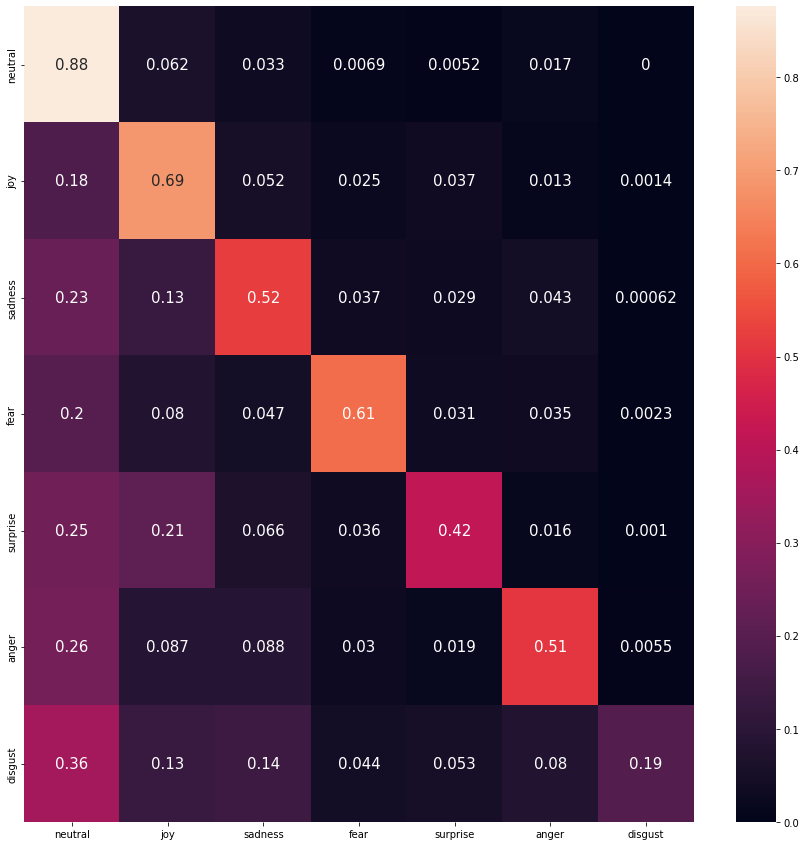

In [38]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['neutral','joy','sadness','fear','surprise','anger','disgust'],columns = ['neutral','joy','sadness','fear','surprise','anger','disgust'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

In [39]:
emotion = ['neutral','joy','sadness','fear','surprise','anger','disgust']

In [46]:
sequence = tokenizer.texts_to_sequences(["this is all wrong I shouldn't be up here I should be back in school on the other side of the ocean yet you all come to us young people for Hope how dare you you have stolen my dreams and my childhood with your empty words and yet I'm one of the lucky ones people are suffering people are dying entire ecosystems are collapsing we are in the beginning of a mass extinction and all you can talk about is the money and fairy tales of Eternal economic growth how dare you"])
test = pad_sequences(sequence, maxlen=max_len)
emotion[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 25ms/step


'anger'

In [47]:
sequence = tokenizer.texts_to_sequences(["thank you thank you thank you thank you to the academy for this all 6,000 members thank you to the other nominees all these performances were impeccable in my opinion I didn't see a false note anywhere I want to thank valet or director Jennifer garnered with daily there's a few things about three things to my account that I need each day one of them is something to look up to another is something to look forward to in another is someone to chase now first off I want to thank God because that's who I look up to he's great my life with opportunities that I know are not of my hand or any other human hand he is showing me that it's a scientific fact that gratitude reciprocates"])
test = pad_sequences(sequence, maxlen=max_len)
emotion[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 24ms/step


'anger'

In [48]:
sequence = tokenizer.texts_to_sequences(["I used to think the whole purpose of life was pursuing happiness everyone said the path to happiness was success so I searched for that ideal job that perfect boyfriend that beautiful apartment but instead of ever feeling fulfilled I felt anxious and the drift and I wasn't alone my friends they struggled with this too"])
test = pad_sequences(sequence, maxlen=max_len)
emotion[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 25ms/step


'neutral'

In [49]:
# save the model to disk
import pickle
filename = 'model-weights.sav'
pickle.dump(best_model, open(filename, 'wb'))

# Preparing model for AWS SageMaker

In [44]:
#Saving weights and tokenizer so we can reduce training time on SageMaker

# serialize model to JSON
model_json = best_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
best_model.save_weights("model-weights.h5")
print("Model saved")

# saving tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('Tokenizer saved')

Model saved
Tokenizer saved
